Homework 4: Sentiment Analysis - Task 3
----

Names & Sections
----
Names: Harishraj Udaya Bhaskar, Aushee Khamesra  (Write these in every notebook you submit. For each partner, write down whether you are a 4120 or a 6120 student.)

Task 3: Train a Logistic Regression Model (20 points)
----

Using `sklearn`'s implementation of `LogisticRegression`, conduct a similar analysis on the performance of a Logistic Regression classifier on the provided data set.

Using the `time` module, you'll compare and contrast how long it takes your home-grown BoW vectorizing function vs. `sklearn`'s `CountVectorizer`.


In [1]:
from sklearn.linear_model import LogisticRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from collections import Counter
import time
import sentiment_utils as sutils

2023-10-28 13:12:21.560608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /Users/harisha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# define constants for the files we are using
TRAIN_FILE = "movie_reviews_train.txt"
DEV_FILE = "movie_reviews_dev.txt"

# load in your data and make sure you understand the format
# Do not print out too much so as to impede readability of your notebook
train_tups = sutils.generate_tuples_from_file(TRAIN_FILE)
dev_tups = sutils.generate_tuples_from_file(DEV_FILE)

# some variables you may want to use
# BINARIZED = True
# USE_COUNT_VECTORIZER = False

In [3]:
from collections import Counter
from scipy.sparse import csr_matrix
import numpy as np

def bow_without_vectorizer(tokenized_documents, test_documents):
    # Build the vocabulary
    vocabulary = list(set(word for tokens in tokenized_documents + test_documents for word in tokens))

    # Create a mapping from word to index in the vocabulary
    word_to_index = {word: index for index, word in enumerate(vocabulary)}

    # Initialize an array to store word counts for each document
    counts_per_document = np.zeros((len(tokenized_documents), len(vocabulary)))

    # Populate the counts array for training data
    for doc_index, tokens in enumerate(tokenized_documents):
        word_counts = Counter(tokens)
        for word, count in word_counts.items():
            if word in word_to_index:
                counts_per_document[doc_index, word_to_index[word]] = count

    # Convert the counts array to a sparse CSR matrix for training data
    sparse_matrix = csr_matrix(counts_per_document)

    # Repeat the process for test data
    test_counts_per_document = np.zeros((len(test_documents), len(vocabulary)))

    for doc_index, tokens in enumerate(test_documents):
        word_counts = Counter(tokens)
        for word, count in word_counts.items():
            if word in word_to_index:
                test_counts_per_document[doc_index, word_to_index[word]] = count

    # Convert the counts array to a sparse CSR matrix for test data
    test_sparse_matrix = csr_matrix(test_counts_per_document)

    return sparse_matrix, test_sparse_matrix



In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def bow_vectorizer(tokenized_documents, test_documents):
    # Combine training and test documents for vectorization
    all_documents = [' '.join(tokens) for tokens in tokenized_documents + test_documents]

    # Create and fit the vectorizer on all documents
    vectorizer = CountVectorizer()
    X_all = vectorizer.fit_transform(all_documents)

    # Separate training and test vectors
    X_train = X_all[:len(tokenized_documents)]
    X_test = X_all[len(tokenized_documents):]
    feature_names=vectorizer.get_feature_names_out()
    

    return X_train, X_test,feature_names

X_train, X_test,feature_names  = bow_vectorizer(train_tups[0], dev_tups[0])


In [5]:
# how much time does it take to featurize the all data with your implementation?

start = time.time()

# YOUR CODE HERE

X_train_without, X_test_without = bow_without_vectorizer(train_tups[0],dev_tups[0])
end = time.time()
print("That took:", end - start, "seconds")



That took: 0.8962812423706055 seconds


In [6]:
# how much time does it take to featurize the all data with sklearn's CountVectorizer?
start = time.time()


# YOUR CODE HERE
X_train, X_test,feature_names  = bow_vectorizer(train_tups[0], dev_tups[0])
end = time.time()
print("That took:", end - start, "seconds")

That took: 0.23427104949951172 seconds


In [7]:
print(X_train_without.shape)
print(X_test_without.shape)
print(X_test.shape)
print(X_train.shape)


(1600, 33084)
(200, 33084)
(200, 24053)
(1600, 24053)


1. How big is your vocabulary using your vectorization function(s)? It contains 30705 tokens in the vocab 
2. How big is your vocabulary using the `CountVectorizer`? It contains 22596 tokens in the vocab

In [8]:
#  write any code you need analyze the relative sparsity of your vectorized representations of the data

# YOUR CODE HERE

# Print out the average % of entries that are zeros in each vector in the vectorized training data
# YOUR CODE HERE

# Assuming you already have the bow_representation from the previous examples

# Calculate sparsity for the entire matrix
sparsity = 1.0 - np.count_nonzero(X_train.toarray()) / float(X_train.shape[0] * X_train.shape[1])
average_sparsity_per_vector = np.mean(np.sum(X_train == 0, axis=1) / X_train.shape[1] * 100)

print("Average sparsity per vector: {:.2f}%".format(average_sparsity_per_vector))
print("Sparsity: {:.4f}".format(sparsity))




/Users/harisha/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Average sparsity per vector: 99.43%
Sparsity: 0.9943


In [9]:
# Using the provided dev set, evaluate your model with precision, recall, and f1 score as well as accuracy
# You may use nltk's implemented `precision`, `recall`, `f_measure`, and `accuracy` functions
# (make sure to look at the documentation for these functions!)
# you will be creating a similar graph for logistic regression and neural nets, so make sure
# you use functions wisely so that you do not have excessive repeated code
# write any helper functions you need in sentiment_utils.py (functions that you'll use in your other notebooks as well)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_tups[1])

predicted_labels=model.predict(X_test)



true_labels=dev_tups[1]
# create a graph of your classifier's performance on the dev set as a function of the amount of training data
# the x-axis should be the amount of training data (as a percentage of the total training data)
# the y-axis should be the performance of the classifier on the dev set
# the graph should have 4 lines, one for each of precision, recall, f1, and accuracy
# the graph should have a legend, title, and axis labels

# takes approx 30 sec on Felix's computer

In [10]:
def calculate_f1_score(X_train,X_test,Y_train,Y_test, multi_class="ovr"):
    model= LogisticRegression(max_iter=1000,solver='lbfgs', multi_class=multi_class)
    model.fit(X_train,Y_train)
    y_pred= model.predict(X_test)
    f1 = f1_score(Y_test,y_pred, average='weighted')
    return (f1)
    

multinomial_nonCountVectoried= calculate_f1_score(X_train_without,X_test_without,train_tups[1],dev_tups[1],'multinomial')
multinomial_CountVectoried= calculate_f1_score(X_train,X_test,train_tups[1],dev_tups[1],'multinomial')
binary_nonCountVectoried= calculate_f1_score(X_train_without,X_test_without,train_tups[1],dev_tups[1])
binar_CountVectoried= calculate_f1_score(X_train,X_test,train_tups[1],dev_tups[1])

print(f' multinomial_nonCountVectoried:{multinomial_nonCountVectoried}')
print(f' multinomial_CountVectoried:{multinomial_CountVectoried}')
print(f' binary_nonCountVectoried:{binary_nonCountVectoried}')
print(f' binary_CountVectoried:{binar_CountVectoried}')


 multinomial_nonCountVectoried:0.77
 multinomial_CountVectoried:0.7796904833685057
 binary_nonCountVectoried:0.77
 binary_CountVectoried:0.7794685990338164


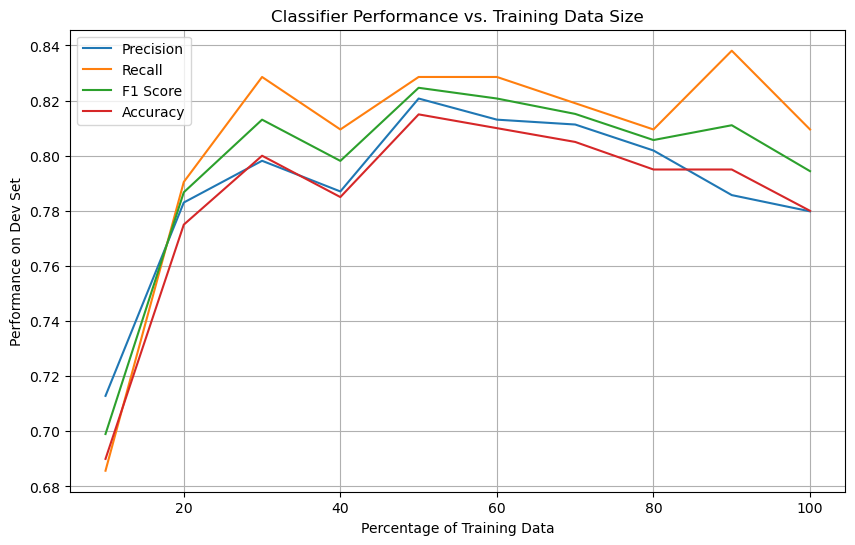

In [19]:
#Producing graph for the best combination settings

sutils.create_training_graph_lr(X_train,train_tups[1],X_test,dev_tups[1])


Test the following 4 combinations to determine which has the best final f1 score for your Logistic Regression model:
- your vectorized features, multinomial: 0.7796904833685057
- CountVectorizer features, multinomial: 0.7796904833685057
- your vectorized features, binarized: 0.7794685990338164
- CountVectorizer features, binarized: 0.7794685990338164

The best f1 score is the one with the countvectorized training data with multinomial class

Produce your graph(s) for the combination with the best final f1 score.




6120 REQUIRED
----

Find the top 100 most important features to your Logistic Regression classifier when using 100% of the training data. To access the weights of your model, you can access the `model.coef_` attribute. You'll want to use a `StandardScalar` preprocessor. This will help us deal with the fact that we expect counts of certain words to be higher (e.g. stop words).

To find the importance of a feature, calculate the absolute value of each weight in the model, then order your features according to the absolute values of these weights. The feature with the heighest absolute value weight has the most importance.

Use __your__ (not CountVectorizer) multinomial vectors for this analysis.

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [13]:
# YOUR CODE HERE
# train a model on the scaled inputs
# This takes Felix's computer about 6.5 sec to run


# Standardize the feature vectors
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

# Create and train the Logistic Regression model
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train_scaled,train_tups[1])

# Get the absolute values of the weights
abs_weights = np.abs(model.coef_)

print(abs_weights)





[[0.00272134 0.02900182 0.01316702 ... 0.02332994 0.00990196 0.0039679 ]]


In [14]:
# print out the top 20 most informative features according to this model

# Get the corresponding feature names from the vocabulary
top_feature_indices = np.argsort(abs_weights)[-1, :20]
top_feature_names = feature_names[top_feature_indices]

# Print or use the top feature names as needed
print("Top 20 most important features:")
print(top_feature_names)


Top 20 most important features:
['questioned' 'mundae' 'arin' 'flushed' 'suffuses' 'mumbled' 'initiation'
 'injecting' 'multiplayer' 'denigrating' 'domini' 'preserving'
 'boleslowski' 'dominican' 'injunction' 'mowry' 'summarily' 'dailies'
 'summarized' 'ardal']


In [15]:
# re-evalaute your LR model with inputs that have been filtered to only use the top 500 most informative features
# Get the corresponding feature names from the vocabulary
top_feature_indices = np.argsort(abs_weights)[-1, :500]

X_train_top_500 = X_train[:, top_feature_indices]
X_test_top_500 = X_test[:, top_feature_indices]


model_500= LogisticRegression(max_iter=1000,solver='lbfgs', multi_class='ovr')
model_500.fit(X_train_top_500.toarray(),train_tups[1])
y_500_predict=model_500.predict(X_test_top_500.toarray())

f1_top_500_test = f1_score(dev_tups[1], y_500_predict, average='weighted')
print(f1_top_500_test)

0.36147540983606563


/Users/harisha/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harisha/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harisha/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


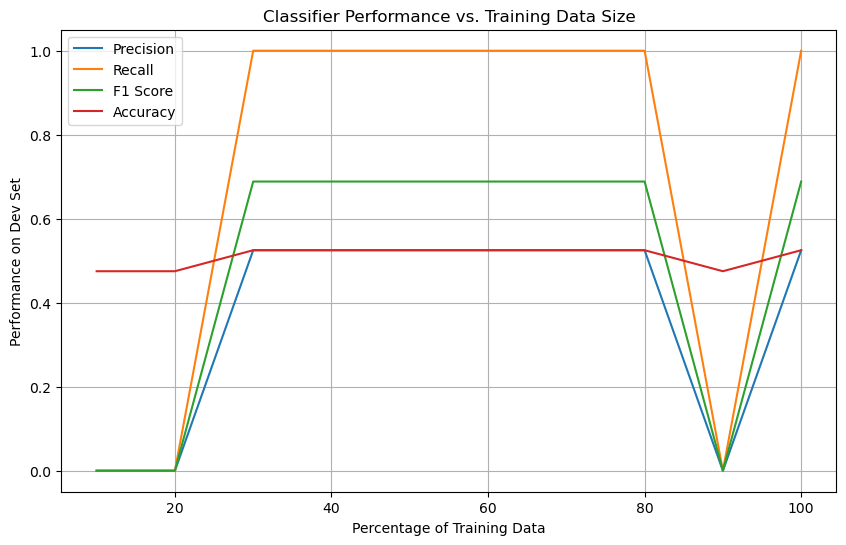

In [21]:
sutils.create_training_graph_lr(X_train_top_500,train_tups[1],X_test_top_500,dev_tups[1])